In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

## Defintions of climate indices

Defintions from:

Defrance, D. (2019). Dataset of global extreme climatic indices due to an acceleration of ice sheet melting during the 21st century. Data in brief, 27, 104585.

In [ ]:
def TNmin(da):
    # Calculate annual minimum temperature
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_minimum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TNmin = min(da_i.values)

                annual_minimum_temperatures[lat, lon, year] = TNmin
    
    return annual_minimum_temperatures



def TXmax(da):
    # Calculate annual maximum temperature
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_maximum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TXmax = max(da_i.values)

                annual_maximum_temperatures[lat, lon, year] = TXmax
    
    return annual_maximum_temperatures

def FD(da):
    # Calculate number of frost days
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_frost_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                FD = int(np.sum(da_i.values < 273.15))
                n_frost_days[lat, lon, year] = FD
    
    return n_frost_days

def ID(da):
    # Calculate number of icing days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_icing_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                ID = int(np.sum(da_i.values < 273.15))
                n_icing_days[lat, lon, year] = ID
    
    return n_icing_days

def TR(da):
    # Calculate number of tropical nights
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_tropical_nights = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TR = int(np.sum(da_i.values < 293.15))
                n_tropical_nights[lat, lon, year] = TR
    
    return n_tropical_nights

def SU(da):
    # Calculate number of summer days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_summer_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                SU = int(np.sum(da_i.values > 298.15))
                n_summer_days[lat, lon, year] = SU
    
    return n_summer_days

def WSDI(da, TXin90):
    # Calculate well spell duration index
    # Input: daily maximum temperature and 90th percentile historical maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    warm_spell_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                non_warm_days = da_i.values < TXin90
                non_warm_days_idx = np.where(non_warm_days)[0]
                WSDI = int(np.sum(np.diff(non_warm_days_idx) >= time_threshold))

                warm_spell_duration_index[lat, lon, year] = WSDI
    
    return warm_spell_duration_index

def CWDI(da, TNin10):
    # Calculate cold wave duration index
    # Input: daily minimum temperature and 10th percentile historical minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    cold_wave_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                non_cold_days = da_i.values > TNin10
                non_cold_days_idx = np.where(non_cold_days)[0]
                CWDI = int(np.sum(np.diff(non_cold_days_idx) >= time_threshold))
                cold_wave_duration_index[lat, lon, year] = CWDI
    
    return cold_wave_duration_index


## Loading relevant climate variables from different models, areas and time periods

CMIP6 data downloaded from https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/

In [3]:
# Define dataset specifics

model_scenario_name = 'NorESM2-LM_ssp126' # Choose a model and SSP scenario
area_name = 'norway' # Choose an area

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
elif model_scenario_name == 'MRI-ESM2_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany': #UPDATE
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load maximum daily temperature data

files = glob.glob(data_folder+'tasmax_day_'+model_scenario_name+'*')
files.sort()
tasmax = xr.open_mfdataset(files)

tmax = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

# Load minimum daily temperature data

files = glob.glob(data_folder+'tasmin_day_'+model_scenario_name+'*')
files.sort()
tasmin = xr.open_mfdataset(files)

tmin = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

## Calculate climatic indices

In [ ]:
TNmin = TNmin(tmin)
ds = xr.Dataset(
    data_vars=dict(
        annual_minimum_temperature=(["lat", "lon", "time"], TNmin)
    ),
    coords=dict(
        lat=tmin.lat.values,
        lon=tmin.lon.values,
        time=np.arange(2015,2055,1),
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'

ds.annual_minimum_temperature.attrs['units'] = 'Kelvin'
ds.annual_minimum_temperature.attrs['description'] = 'Annual minimum temperature'

print(ds)
ds.to_netcdf(save_folder+'TNmin_'+area_name+'_'+model_scenario_name+'.nc')

<xarray.Dataset> Size: 34kB
Dimensions:                     (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat                         (lat) float64 64B 57.79 59.68 ... 69.16 71.05
  * lon                         (lon) float64 104B 2.5 5.0 7.5 ... 30.0 32.5
  * time                        (time) int64 320B 0 1 2 3 4 5 ... 35 36 37 38 39
Data variables:
    annual_minimum_temperature  (lat, lon, time) float64 33kB 273.4 ... 258.0
Attributes:
    description:  Annual minimum temperature
    units:        days


In [ ]:
TXmax = TXmax(tmax)
ds = xr.Dataset(
    data_vars=dict(
        annual_maximum_temperature=(["lat", "lon", "time"], TXmax)
    ),
    coords=dict(
        lat=tmin.lat.values,
        lon=tmin.lon.values,
        time=np.arange(2015,2055,1),
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'

ds.annual_maximum_temperature.attrs['units'] = 'Kelvin'
ds.annual_maximum_temperature.attrs['description'] = 'Annual maximum temperature'


print(ds)
ds.to_netcdf(save_folder+'TXmax_'+area_name+'_'+model_scenario_name+'.nc')

0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
<xarray.Dataset> Size: 34kB
Dimensions:                     (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat                         (lat) float64 64B 57.79 59.68 ... 69.16 71.05
  * lon                         (lon) float64 104B 2.5 5.0 7.5 ... 30.0 32.5
  * time                        (time) int64 320B 2015 2016 2017 ... 2053 2054
Data variables:
    annual_maximum_temperature  (lat, lon, time) float64 33kB 289.1 ... 284.7
Attributes:
    description:  Annual maximum temperature
    units:        Kelvin


In [37]:
FD = FD(tmin)
ds = xr.Dataset(
    data_vars=dict(
        FD=(["lat", "lon", "time"], FD)
    ),
    coords=dict(
        lat=tmin.lat.values,
        lon=tmin.lon.values,
        time=np.arange(2015,2055,1),
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'

ds.FD.attrs['units'] = 'days'
ds.FD.attrs['description'] = 'Number of frost days'


print(ds)
ds.to_netcdf(save_folder+'FD_'+area_name+'_'+model_scenario_name+'.nc')

0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
<xarray.Dataset> Size: 34kB
Dimensions:  (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
  * time     (time) int64 320B 2015 2016 2017 2018 2019 ... 2051 2052 2053 2054
Data variables:
    FD       (lat, lon, time) float64 33kB 0.0 4.0 2.0 2.0 ... 154.0 151.0 154.0


In [ ]:
ID = ID(tmax)
ds = xr.Dataset(
    data_vars=dict(
        ID=(["lat", "lon", "time"], ID)
    ),
    coords=dict(
        lat=tmin.lat.values,
        lon=tmin.lon.values,
        time=np.arange(2015,2055,1),
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'

ds.ID.attrs['units'] = 'days'
ds.ID.attrs['description'] = 'Number of icing days'


print(ds)
ds.to_netcdf(save_folder+'ID_'+area_name+'_'+model_scenario_name+'.nc')

<xarray.Dataset> Size: 34kB
Dimensions:  (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
  * time     (time) int64 320B 2015 2016 2017 2018 2019 ... 2051 2052 2053 2054
Data variables:
    ID       (lat, lon, time) float64 33kB 0.0 1.0 0.0 1.0 ... 121.0 98.0 130.0


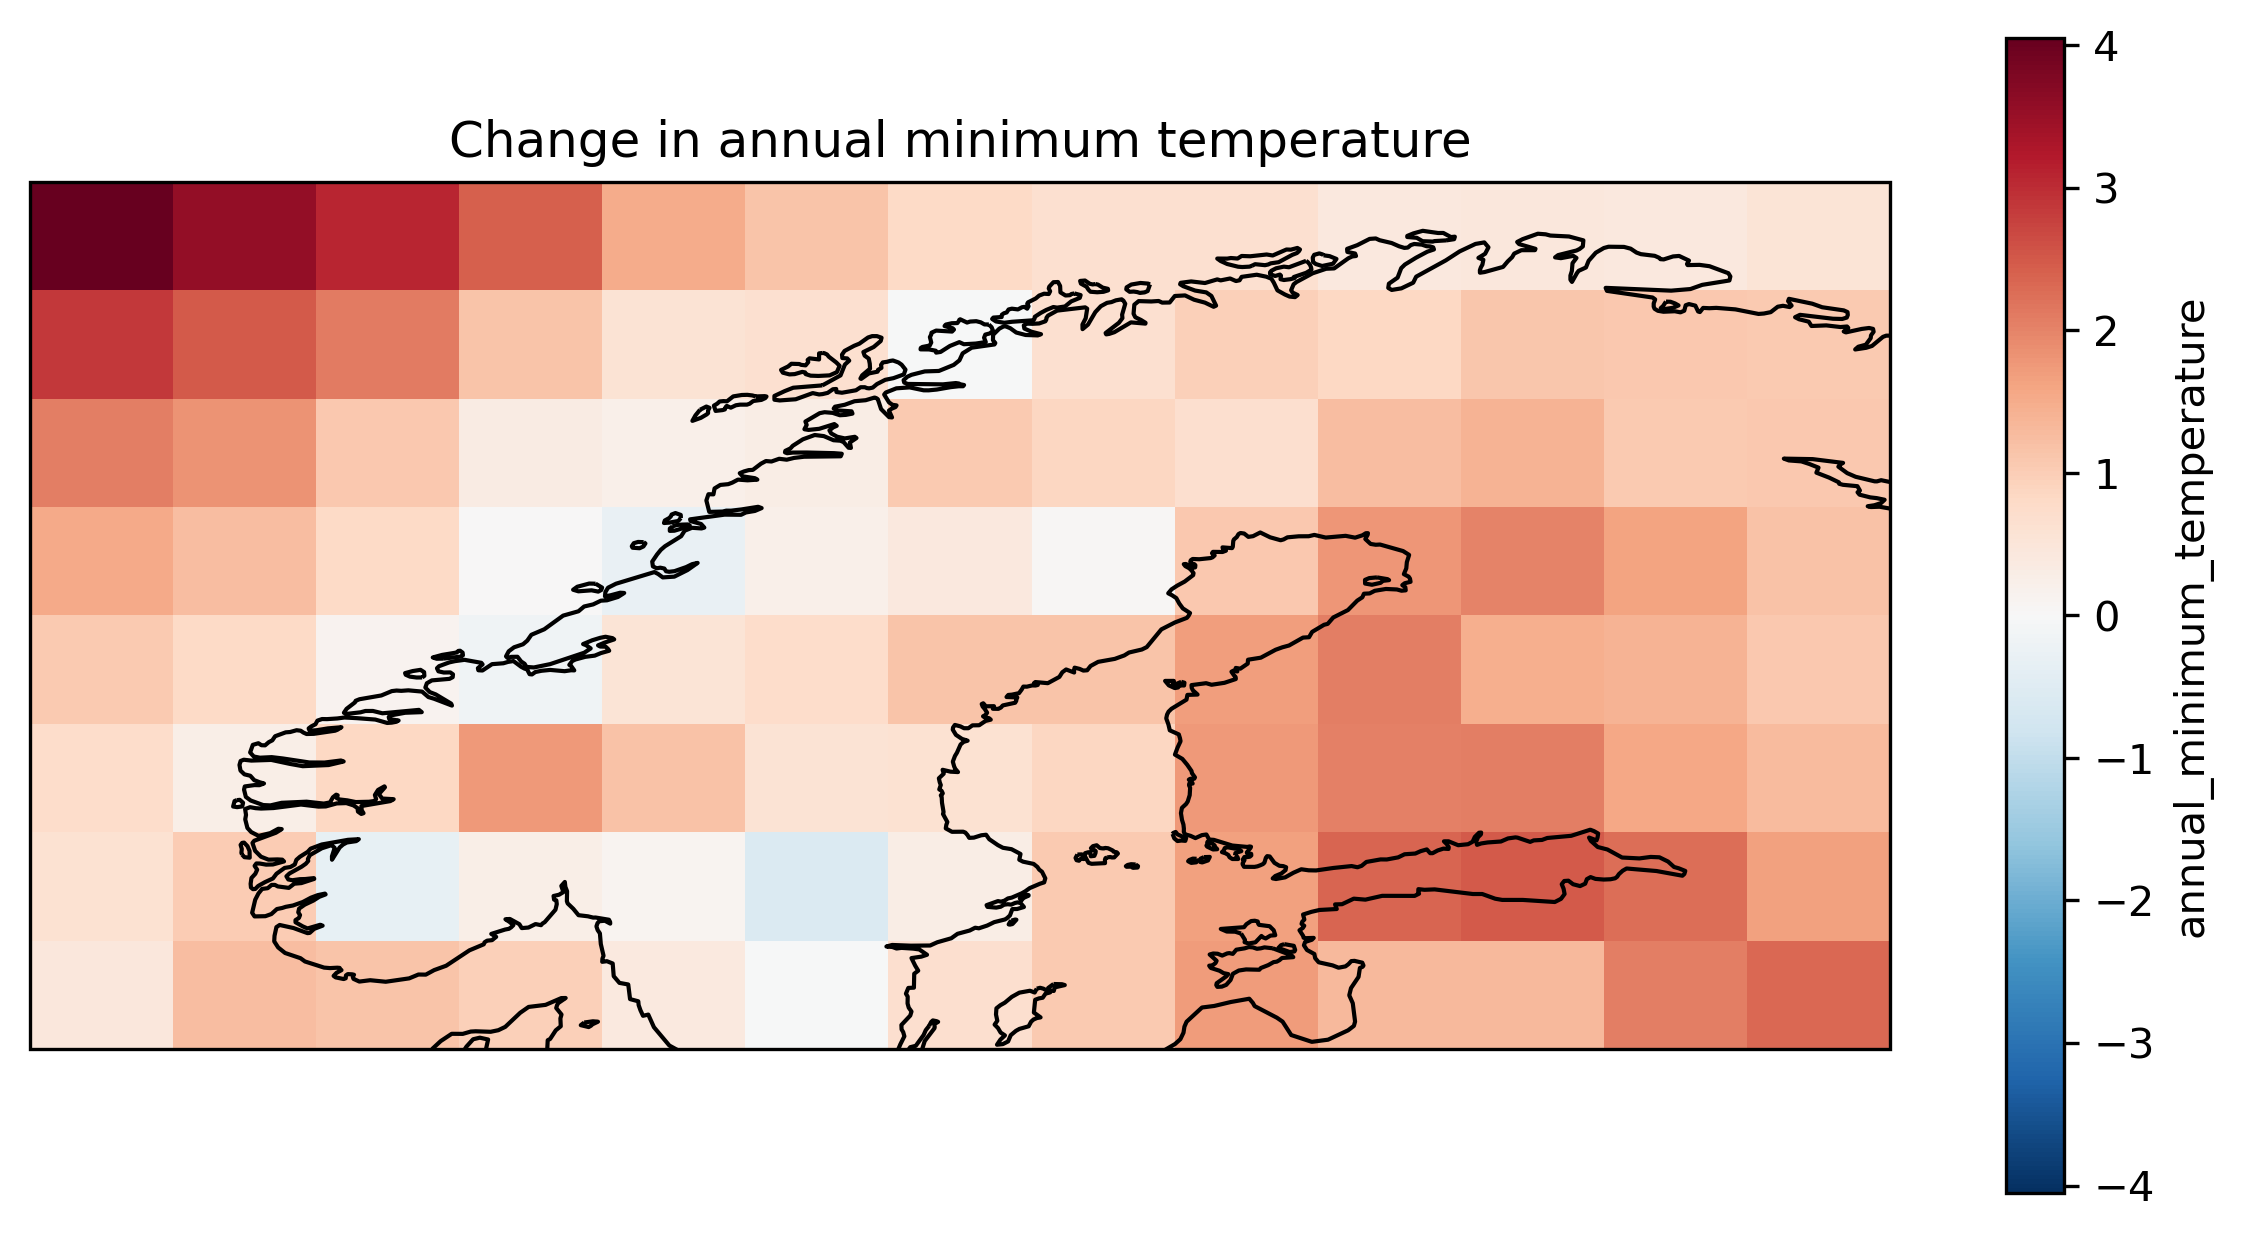

41


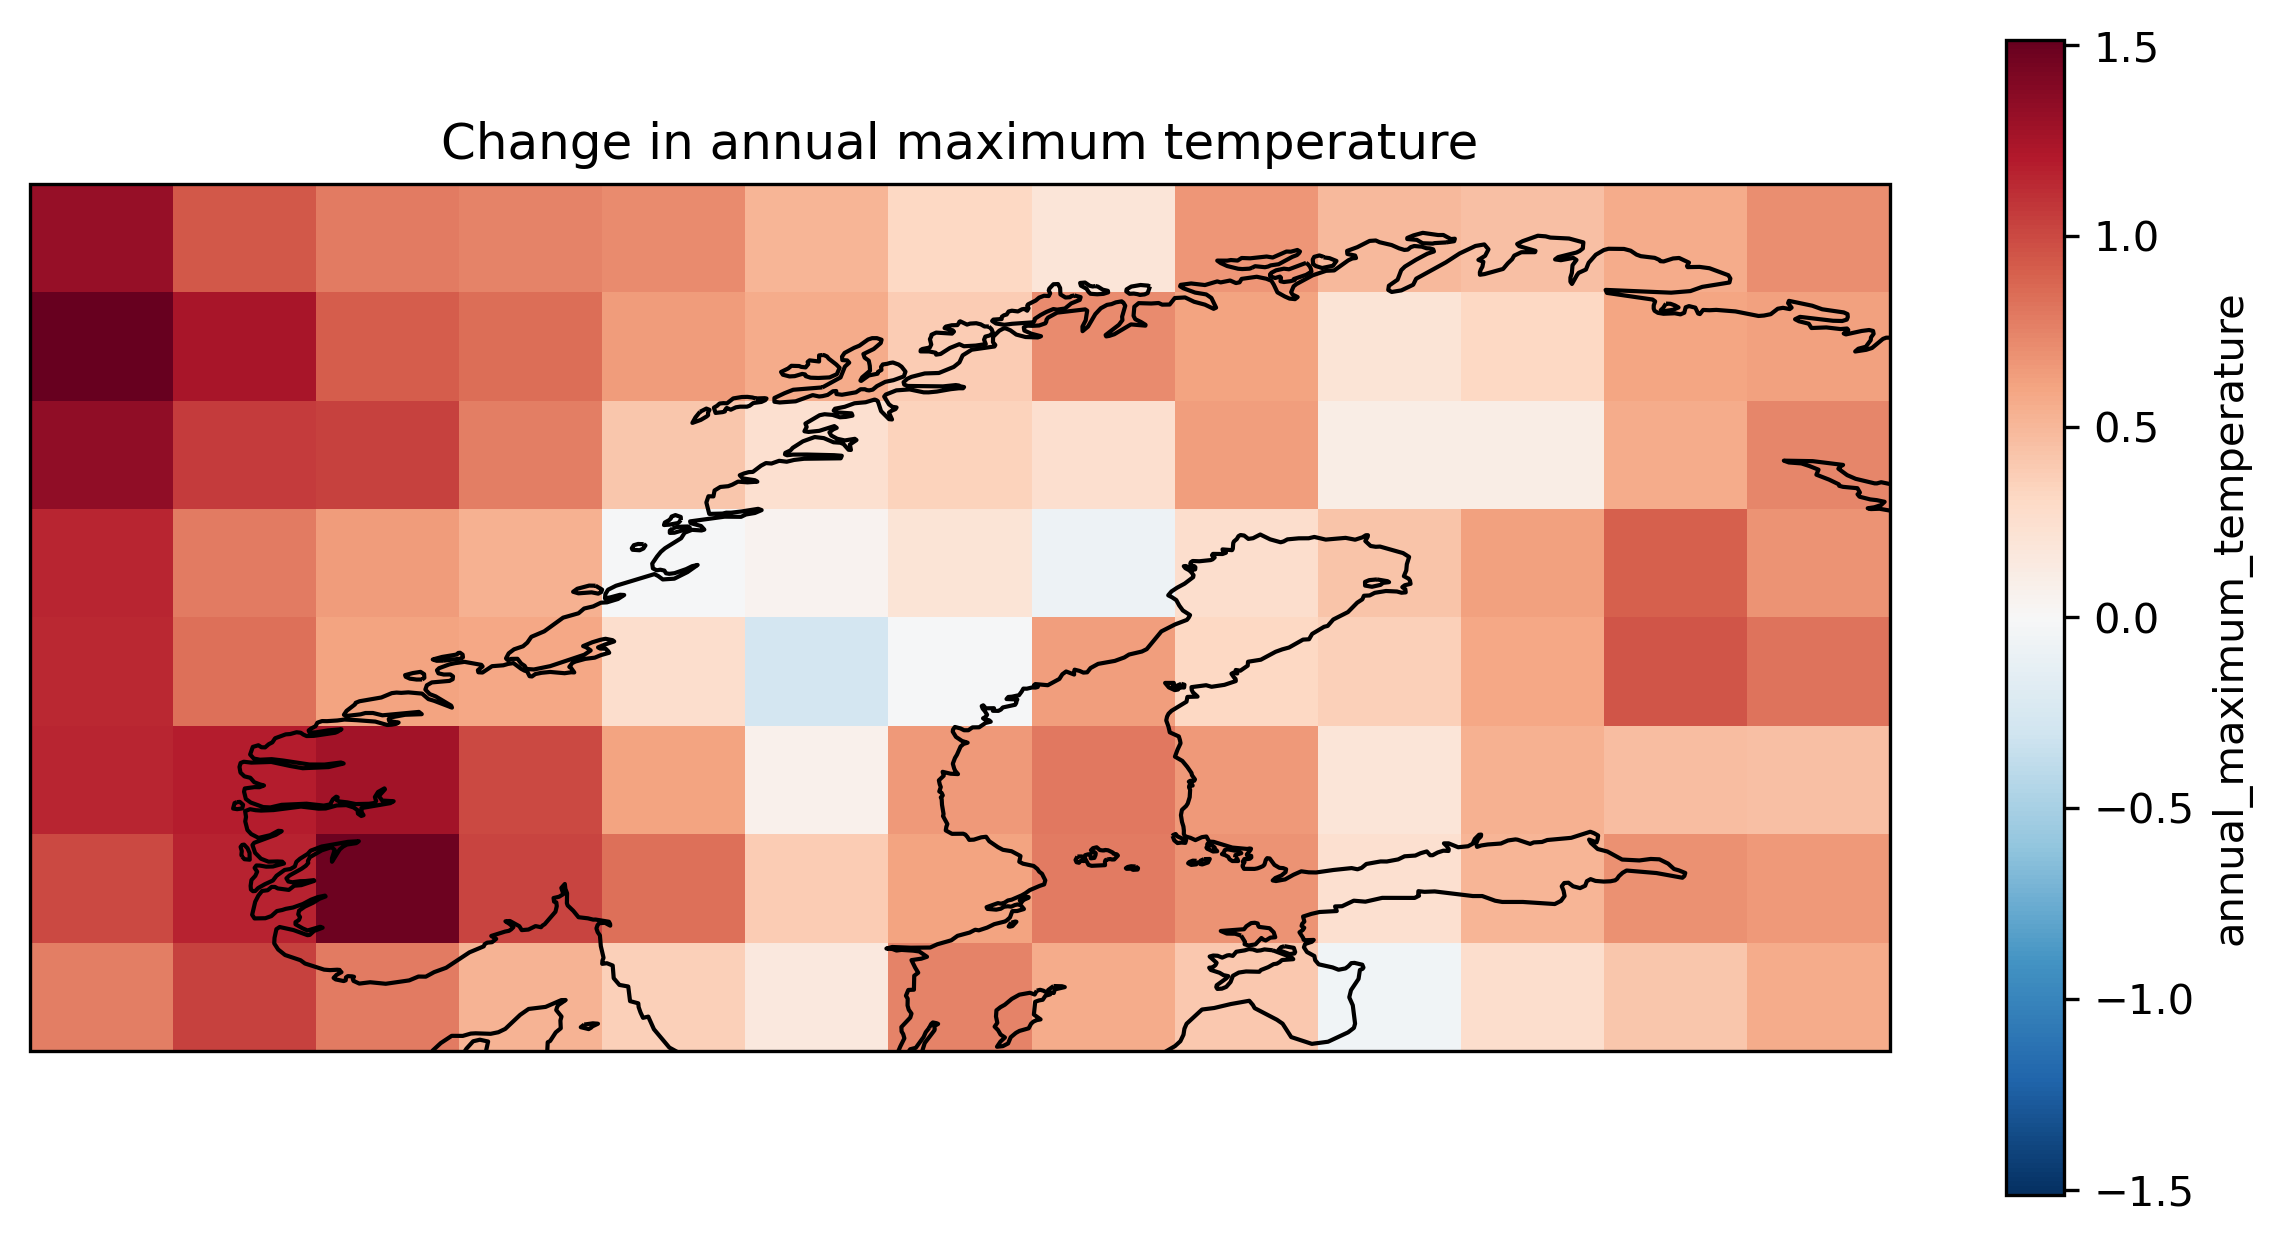

In [21]:
ds = xr.open_dataset(save_folder+'TNmin_'+area_name+'_'+model_scenario_name+'.nc')
data = ds.annual_minimum_temperature
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in annual minimum temperature")
plt.show()
fig.clear()

ds = xr.open_dataset(save_folder+'TXmax_'+area_name+'_'+model_scenario_name+'.nc')
data = ds.annual_maximum_temperature
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in annual maximum temperature")

print(len(np.arange(2015,2056,1)))